In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import spherical_geometry as sg
from spherical_geometry.polygon import SphericalPolygon

In [2]:
import xarray as xr

In [3]:
url_lam = "https://mllam-test-data.s3.eu-north-1.amazonaws.com/height_levels.zarr"
url_boundary = "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr"

In [4]:
ds_lam = xr.open_zarr(url_lam)
ds_lam

<xarray.Dataset> Size: 1GB
Dimensions:   (altitude: 1, y: 589, x: 789, time: 100)
Coordinates:
  * altitude  (altitude) int64 8B 100
    lat       (y, x) float64 4MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    lon       (y, x) float64 4MB dask.array<chunksize=(256, 256), meta=np.ndarray>
  * time      (time) datetime64[ns] 800B 1990-09-01 ... 1990-09-13T09:00:00
  * x         (x) float64 6kB -1.999e+06 -1.997e+06 ... -3.175e+04 -2.925e+04
  * y         (y) float64 5kB -6.095e+05 -6.07e+05 ... 8.58e+05 8.605e+05
Data variables:
    r         (altitude, time, y, x) float64 372MB dask.array<chunksize=(1, 100, 256, 256), meta=np.ndarray>
    t         (altitude, time, y, x) float64 372MB dask.array<chunksize=(1, 100, 256, 256), meta=np.ndarray>
    u         (altitude, time, y, x) float64 372MB dask.array<chunksize=(1, 100, 256, 256), meta=np.ndarray>
    v         (altitude, time, y, x) float64 372MB dask.array<chunksize=(1, 100, 256, 256), meta=np.ndarray>
Attributes:
    description:  All prognostic variables for 10-year period on reduced levels

In [5]:
ds_boundary = xr.open_zarr(url_boundary)
ds_boundary

<xarray.Dataset> Size: 175GB
Dimensions:                                           (time: 93544,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 256B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 512B ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    above_ground                                      (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    vorticity                                         (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [6]:
def get_latlon_arrays(ds, lon='longitude', lat='latitude'):
    da_lon = ds[lon]
    da_lat = ds[lat]

    # check if lat and lon dataarrays share dimensions, otherwise we need to
    # broadcast
    if da_lon.dims != da_lat.dims:
        lons, lats = np.meshgrid(da_lon.values, da_lat.values)
        lons = lons.flatten()
        lats = lats.flatten()
    else:
        lons = da_lon.values.flatten()
        lats = da_lat.values.flatten()
        
    return lons, lats


In [7]:
k = 10
ds_lam_subsampled = ds_lam.isel(x=slice(None, None, k), y=slice(None, None, k))
points_bnd = np.array(get_latlon_arrays(ds_boundary)).T
points_lam = np.array(get_latlon_arrays(ds_lam_subsampled, lon='lon', lat='lat')).T

points_bnd.shape, points_lam.shape

((2048, 2), (4661, 2))

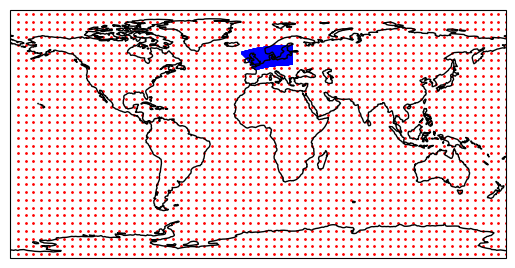

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.scatter(points_bnd[:, 0], points_bnd[:, 1], color='red', s=1)
ax.scatter(points_lam[:, 0], points_lam[:, 1], color='blue', s=1)

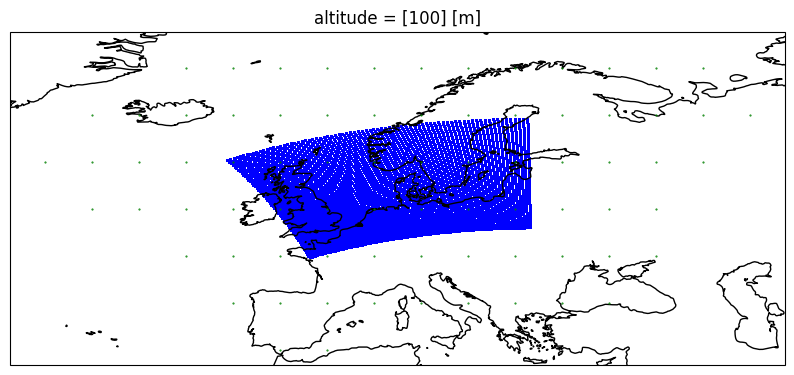

In [9]:
# latlon to cartesian coords
pts_bnd_x = np.array(sg.vector.lonlat_to_vector(points_bnd[:,0], points_bnd[:,1])).T
pts_lam_x = np.array(sg.vector.lonlat_to_vector(points_lam[:,0], points_lam[:,1])).T

chull_lam = SphericalPolygon.convex_hull(pts_lam_x)

# Finding the boundary points inside the convec hull is what takes time. Possibly speed up by restricting to a subset of points_bnd that are within some distance from area center or similar?
msk_in = np.array([chull_lam.contains_lonlat(x[1], x[0]) for x in points_bnd])

# Distances from all boundary points outside the region to the closest point inside
d = np.array([np.min(np.arccos(np.dot(pts_lam_x, x))) for x in pts_bnd_x[~msk_in]])

# Define boundary distance and mask boundary points outside that are closer
# This is now in radians but should be defined as meters based on Earth radius
ii = d < 0.2

# Plot boundary valid boundary points outside and the LAM interior points (subset)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
ax.coastlines()
# xr.plot.scatter(ds_boundary, x='longitude', y='latitude', color='red', s=1, ax=ax, transform=ccrs.Geodetic())
xr.plot.scatter(ds_lam_subsampled, x='lon', y='lat', color='blue', s=1, ax=ax, transform=ccrs.Geodetic())
ax.plot(points_bnd[~msk_in,0][ii], points_bnd[~msk_in,1][ii], '.', color='green', markersize=1, transform=ccrs.Geodetic())

In [10]:
ii

array([False, False, False, ..., False, False, False])